/tmp/ipykernel_35/1627400891.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[column].replace(missing_value_placeholders, np.nan, inplace=True)
/tmp/ipykernel_35/1627400891.py:38: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

'id' 열에는 결측치가 없습니다.
'gender' 열에는 결측치가 없습니다.
'masterCategory' 열에는 결측치가 없습니다.
'subCategory' 열에는 결측치가 없습니다.
'articleType' 열에는 결측치가 없습니다.
'baseColour' 열에는 결측치가 없습니다.
'season' 열에는 결측치가 없습니다.
'year' 열에는 결측치가 없습니다.
'usage' 열에는 결측치가 없습니다.
'productDisplayName' 열에는 결측치가 없습니다.
다음 ID는 이미지가 없습니다: {'39410', '39425', '39403', '39401', '12347'}
data-preprocessing end..

data-loader end..



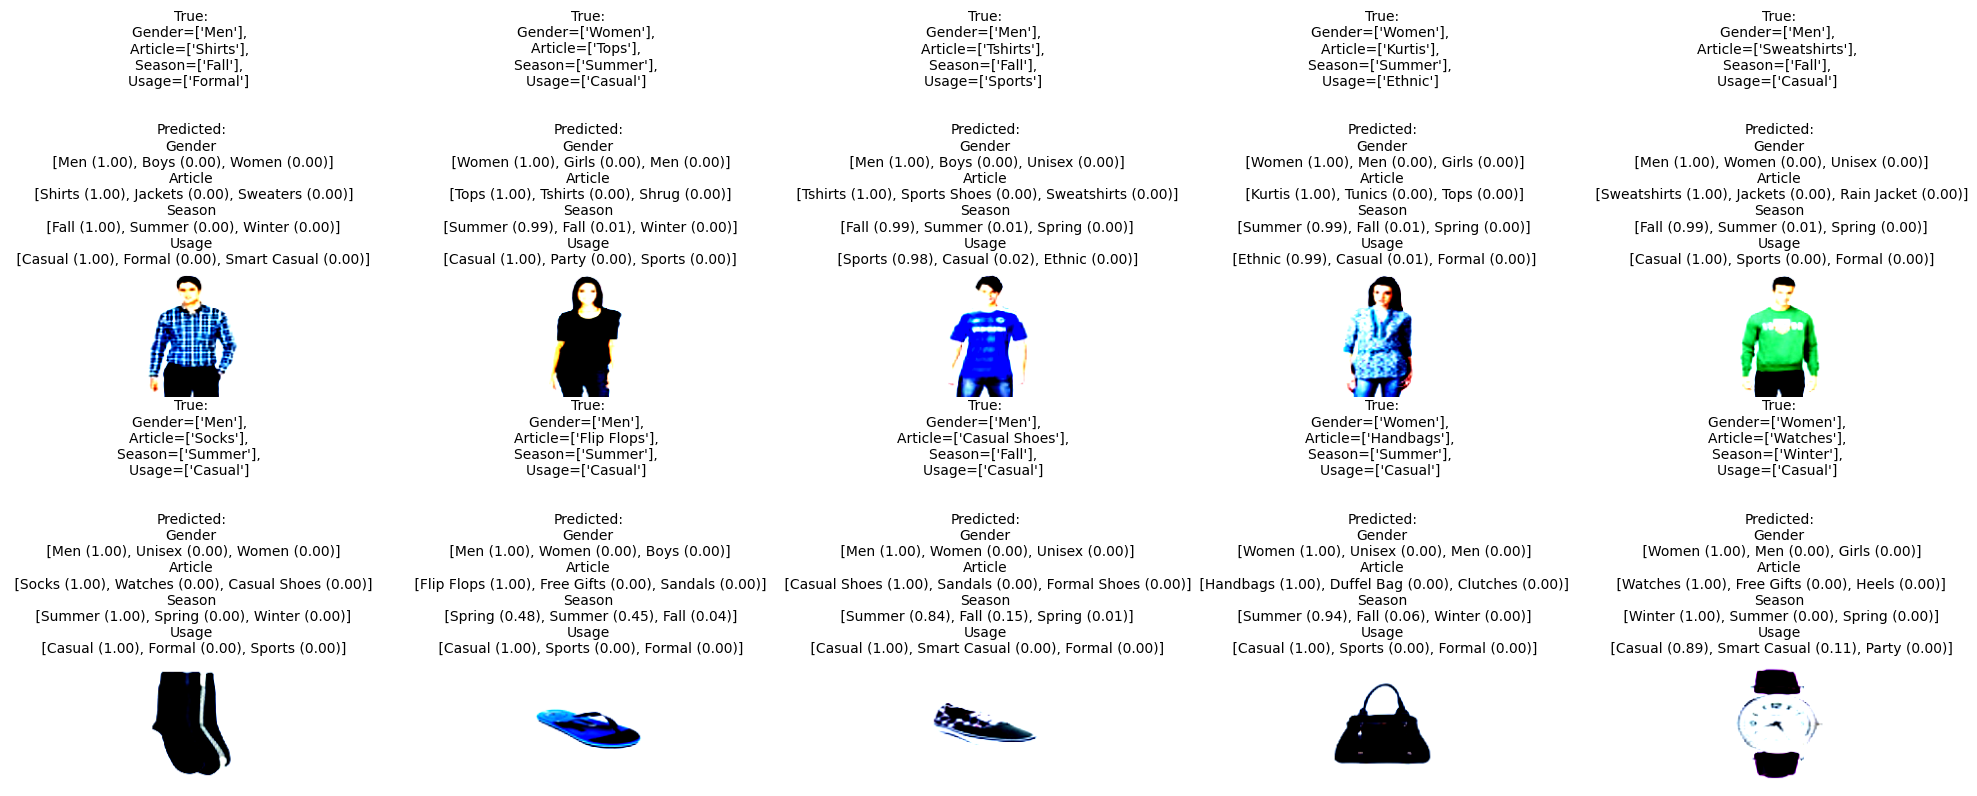

In [19]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datetime import datetime
from pytz import timezone
import numpy as np
from gensim.models import KeyedVectors

import matplotlib.pyplot as plt
import torch.nn.functional as F

root_imageset_dir = "/kaggle/input/fashion-product-images-small/images"
root_work_weight_dir = "/kaggle/input/fashion-w"

y_columns = ['gender', 'articleType', 'season', 'usage']
x_columns = ['masterCategory', 'subCategory', 'baseColour', 'year', 'productDisplayName']
# Load the data
data = pd.read_csv('/kaggle/input/fashion-product-images-small/styles.csv', on_bad_lines='skip')

# Define common placeholders for missing values
missing_value_placeholders = ['', ' ', '-', 'None', 'NA', 'N/A', 'null']

# Convert all placeholders to NaN
for column in y_columns + x_columns:
    data[column].replace(missing_value_placeholders, np.nan, inplace=True)

# Handle missing values - Ensure no NaNs
for column in y_columns + x_columns:
    if data[column].isnull().sum() > 0:  # Check if there are any NaNs
        data[column].fillna(data[column].mode().iloc[0], inplace=True)

# Label encoding for categorical features
label_encoders = {}
for column in y_columns + x_columns[:-1]:  # Skip productDisplayName
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Check for missing values in each column
for column in data.columns:
    missing_indices = data[data[column].isnull()].index.tolist()
    if missing_indices:
        print(f"'{column}' 열의 결측치가 있습니다: {missing_indices}")
    else:
        print(f"'{column}' 열에는 결측치가 없습니다.")

# List all image files in the directory
image_files = os.listdir(root_imageset_dir)
image_files = [f for f in image_files if f.endswith('.jpg')]

# Extract IDs from image filenames
image_ids = {os.path.splitext(f)[0] for f in image_files}

# Get the IDs from the DataFrame
data_ids = set(data['id'].astype(str))

# Find IDs in data that do not have corresponding images
missing_image_ids = data_ids - image_ids
if missing_image_ids:
    print(f"다음 ID는 이미지가 없습니다: {missing_image_ids}")

# Filter the DataFrame to only include rows with available images
data = data[data['id'].astype(str).isin(image_ids)].reset_index(drop=True)

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    data[['id'] + x_columns], 
    data[y_columns], 
    test_size=0.3, 
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, 
    y_temp, 
    test_size=0.5, 
    random_state=42
)

print("data-preprocessing end..\n")

# Load Word2Vec embeddings
word2vec_path = '/kaggle/input/googlenewsvectorsnegative300/GoogleNews-vectors-negative300.bin'  # Word2Vec 모델 경로
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to embed product display name using Word2Vec
def embed_product_display_name(product_display_names):
    embedded_vectors = []
    for name in product_display_names:
        words = name.split()
        word_vectors = [word2vec[word] for word in words if word in word2vec]
        if word_vectors:
            embedded_vectors.append(np.mean(word_vectors, axis=0))
        else:
            embedded_vectors.append(np.zeros(300))  # Word2Vec 벡터 차원
    return torch.tensor(embedded_vectors, dtype=torch.float32).to(device)

class FashionDataset(Dataset):
    def __init__(self, X, y, root_dir, transform=None):
        self.X = X.reset_index(drop=True)  # Reset index to ensure consistency
        self.y = y.reset_index(drop=True)  # Reset index to ensure consistency
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, str(self.X.iloc[idx]['id']) + '.jpg')
        image = Image.open(img_name).convert('RGB')  # Ensure image is RGB

        if self.transform:
            image = self.transform(image)

        # Access the label using the correct column structure
        gender_idx = int(self.y.iloc[idx, 0])  # Adjust indexing to single integer
        article_idx = int(self.y.iloc[idx, 1])
        season_idx = int(self.y.iloc[idx, 2])
        usage_idx = int(self.y.iloc[idx, 3])

        # Encode additional features
        master_category_idx = float(self.X.iloc[idx]['masterCategory'])
        sub_category_idx = float(self.X.iloc[idx]['subCategory'])
        base_colour_idx = float(self.X.iloc[idx]['baseColour'])
        year = float(self.X.iloc[idx]['year'])

        # Get the text embedding
        product_display_name_embedding = embed_product_display_name([self.X.iloc[idx]['productDisplayName']])

        # Convert labels to one-hot encoded vectors
        gender_one_hot = np.eye(num_gender)[gender_idx]
        article_one_hot = np.eye(num_article)[article_idx]
        season_one_hot = np.eye(num_season)[season_idx]
        usage_one_hot = np.eye(num_usage)[usage_idx]

        labels = {
            'gender': torch.tensor(gender_one_hot, dtype=torch.float),
            'articleType': torch.tensor(article_one_hot, dtype=torch.float),
            'season': torch.tensor(season_one_hot, dtype=torch.float),
            'usage': torch.tensor(usage_one_hot, dtype=torch.float)
        }

        features = {
            'image': image,
            'masterCategory': torch.tensor(master_category_idx, dtype=torch.float).to(device),
            'subCategory': torch.tensor(sub_category_idx, dtype=torch.float).to(device),
            'baseColour': torch.tensor(base_colour_idx, dtype=torch.float).to(device),
            'year': torch.tensor(year, dtype=torch.float).to(device),
            'productDisplayName': product_display_name_embedding.squeeze(0)  # Ensure it is 1D for concatenation
        }

        return features, labels

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets with consistent label structure
train_dataset = FashionDataset(
    X_train,
    y_train,
    root_dir=root_imageset_dir,
    transform=transform
)

val_dataset = FashionDataset(
    X_val,
    y_val,
    root_dir=root_imageset_dir,
    transform=transform
)

test_dataset = FashionDataset(
    X_test,
    y_test,
    root_dir=root_imageset_dir,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print("data-loader end..\n")

max_epoch=15
# Load the saved model with the best weights
model.load_state_dict(torch.load(os.path.join(root_work_weight_dir, f"train_{max_epoch}.pth")))
model.eval()

# Helper function to decode one-hot vectors
def decode_one_hot(one_hot_vector, label_encoder):
    return label_encoder.inverse_transform([np.argmax(one_hot_vector)])

# Create a mapping from index to class names for each output
gender_classes = label_encoders['gender'].inverse_transform(range(num_gender))
article_classes = label_encoders['articleType'].inverse_transform(range(num_article))
season_classes = label_encoders['season'].inverse_transform(range(num_season))
usage_classes = label_encoders['usage'].inverse_transform(range(num_usage))

# Function to display the top N predictions with confidence
def display_top_predictions(predictions, classes, top_n=3):
    softmax_scores = F.softmax(predictions, dim=1)
    top_confidences, top_indices = torch.topk(softmax_scores, top_n, dim=1)
    top_classes = [classes[idx] for idx in top_indices[0].cpu().numpy()]
    top_confidences = top_confidences[0].cpu().numpy()

    return top_classes, top_confidences

# Visualize predictions on test data
num_samples = 0  # Initialize counter for displayed samples
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Create a grid for 10 images
axes = axes.flatten()

with torch.no_grad():
    for features, labels in test_loader:
        images = features['image'].to(device).float()
        additional_features = torch.cat([
            features['masterCategory'].unsqueeze(1),
            features['subCategory'].unsqueeze(1),
            features['baseColour'].unsqueeze(1),
            features['year'].unsqueeze(1),
            features['productDisplayName'].to(device)
        ], dim=1)

        # Forward pass
        gender_output, article_output, season_output, usage_output = model(images, additional_features)

        # Plot each image and its predictions
        for i in range(len(images)):
            if num_samples >= 10:  # Stop after displaying 10 samples
                break

            ax = axes[num_samples]
            ax.imshow(images[i].cpu().permute(1, 2, 0).numpy())
            ax.axis('off')

            # Display true labels
            true_labels = (
                f"True:\nGender={decode_one_hot(labels['gender'][i].cpu().numpy(), label_encoders['gender'])}, \n"
                f"Article={decode_one_hot(labels['articleType'][i].cpu().numpy(), label_encoders['articleType'])}, \n"
                f"Season={decode_one_hot(labels['season'][i].cpu().numpy(), label_encoders['season'])}, \n"
                f"Usage={decode_one_hot(labels['usage'][i].cpu().numpy(), label_encoders['usage'])} \n"
            )

            # Get top 3 predictions for each category
            top_gender, conf_gender = display_top_predictions(gender_output[i:i+1], gender_classes)
            top_article, conf_article = display_top_predictions(article_output[i:i+1], article_classes)
            top_season, conf_season = display_top_predictions(season_output[i:i+1], season_classes)
            top_usage, conf_usage = display_top_predictions(usage_output[i:i+1], usage_classes)

            # Format predictions with confidence scores
            pred_labels = (
                f"Predicted:\n"
                f"Gender\n [{', '.join([f'{cls} ({conf:.2f})' for cls, conf in zip(top_gender, conf_gender)])}]\n"
                f"Article\n [{', '.join([f'{cls} ({conf:.2f})' for cls, conf in zip(top_article, conf_article)])}]\n"
                f"Season\n [{', '.join([f'{cls} ({conf:.2f})' for cls, conf in zip(top_season, conf_season)])}]\n"
                f"Usage\n [{', '.join([f'{cls} ({conf:.2f})' for cls, conf in zip(top_usage, conf_usage)])}]"
            )

            # Display titles
            ax.set_title(f"{true_labels}\n\n{pred_labels}", fontsize=10)

            num_samples += 1

        if num_samples >= 10:
            break

plt.tight_layout()
plt.show()
